(20, 40)


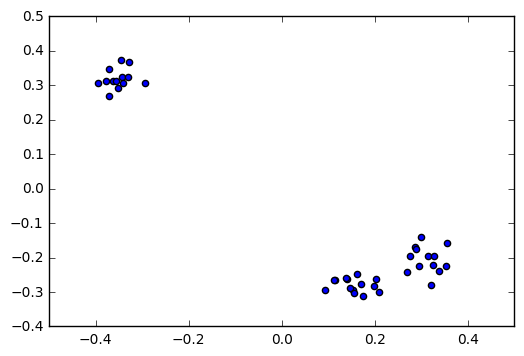

In [1]:
import scipy
from sklearn.preprocessing import normalize
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
#print randn(40,30)
#print scipy.sparse.rand(30,30,density=0.01)
D = 20
K = 40
X, _ = make_blobs(n_samples=K, centers=3, n_features=D)
X = X.T
#X = np.random.randn(D,K)
#X = np.array([[1, 3, 1, 3],[-1,-1,3,3],[3,3,3,1]]).T.astype(float)
normalize(X, norm='l2', axis=0, copy=False, return_norm=True)
#print X.T
np.savetxt('X_{}_{}'.format(D, K), X.T, delimiter=' ', fmt='%.5f')

print X.shape
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[0,:], X[1,:])
plt.show()

In [2]:
r = 2000
beta = scipy.sparse.rand(K,r,density=0.2)
y = (X * beta)
np.savetxt('y_{}_{}'.format(D, r), y.T, delimiter=' ', fmt='%.5f')

## use learned dictionary to solve the sparse coding, and calculate the error

In [3]:
from sklearn.decomposition import sparse_encode
from sklearn.decomposition import DictionaryLearning, dict_learning_online
alpha = 0.5
"""
dl = DictionaryLearning(K, transform_algorithm='lars', alpha=alpha, transform_alpha=alpha, max_iter=500)
dl.fit(y[:,:r/2].T)
dictionary = dl.components_
code = sparse_encode(y[:,r/2:].T, dictionary, algorithm='lars', alpha=0.5)
"""
_, dictionary = dict_learning_online(y[:,:r/2].T, n_components=K, alpha=alpha, n_iter=500, dict_init=None, batch_size=1, shuffle=False, method='lars', inner_stats=None)
code = sparse_encode(y[:,r/2:].T, dictionary, algorithm='lars', alpha=0.5)
print code.shape
np.set_printoptions(precision=3, suppress=True)
print code

recovery = code.dot(dictionary)
error = np.linalg.norm(recovery - y[:,r/2:].T, axis=1)
print np.sum(np.square(recovery - y[:,r/2:].T))/sum(np.linalg.norm(y[:,r/2:], axis=0) > 0)
print "max/min =", np.max(error), np.min(error)
print "# nozero vector = ", sum(np.linalg.norm(y[:,r/2:], axis=0) > 0)

(1000, 40)
[[ 2.355  0.     0.    ...,  0.     0.     0.   ]
 [ 0.     0.832  0.    ...,  0.     0.     0.   ]
 [ 0.     0.    -1.075 ...,  0.     0.     0.   ]
 ..., 
 [ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.     0.     0.    ..., -0.627  0.     0.   ]
 [ 0.     0.    -1.218 ...,  0.     0.     0.   ]]
1.02128212268
max/min = 4.14335765771 0.0218542126902
# nozero vector =  1000


## use true dictionary

In [4]:
code = sparse_encode(y[:,r/2:].T, X.T, algorithm='lars', alpha=0.5)
recovery = code.dot(X.T)
error = np.linalg.norm(recovery - y[:,r/2:].T, axis=1)
print np.sum(np.square(recovery - y[:,r/2:].T))/sum(np.linalg.norm(y[:,r/2:], axis=0) > 0)
print "max/min =", np.max(error), np.min(error)
print np.square(recovery - y[:,r/2:].T)

3.47104485072
max/min = 4.91709523484 0.0891024813536
[[ 0.     0.001  0.002 ...,  0.335  0.037  0.016]
 [ 0.     0.035  0.006 ...,  0.63   0.022  0.062]
 [ 0.005  0.003  0.    ...,  0.772  0.173  0.026]
 ..., 
 [ 0.005  0.     0.106 ...,  0.861  0.008  0.209]
 [ 0.006  0.025  0.03  ...,  0.01   0.034  0.004]
 [ 0.001  0.008  0.009 ...,  0.389  0.042  0.039]]


## use random dictionary

In [5]:
random_dict = np.random.randn(K, D)
code = sparse_encode(y[:,r/2:].T, random_dict, algorithm='lars', alpha=0.5)
recovery = code.dot(random_dict)
error = np.linalg.norm(recovery - y[:,r/2:].T, axis=1)
print np.sum(np.square(recovery - y[:,r/2:].T))/sum(np.linalg.norm(y[:,r/2:], axis=0) > 0)
print "max/min =", np.max(error), np.min(error)

7.51709016409
max/min = 5.54883482449 0.103009963737


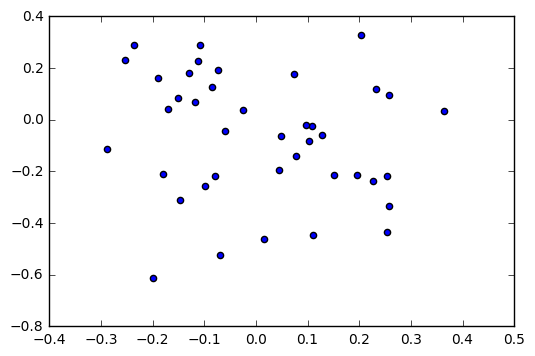

In [6]:
X = dictionary.T
plt.figure()
plt.scatter(X[0,:], X[1,:])
plt.show()

# sparse coding of images

In [60]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import dict_learning_online
from sklearn.decomposition import sparse_encode
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from skimage.transform import resize

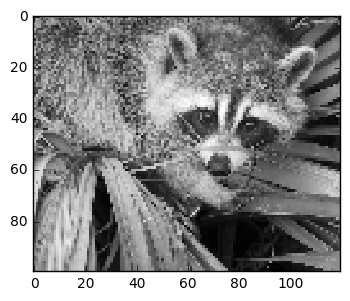

Extracting patches from the left half...
done in 0.00s.
(5076, 49)


In [71]:
try:
    from scipy import misc
    face = misc.face(gray=True)
except AttributeError:
    # Old versions of scipy have face in the top level package
    face = sp.face(gray=True)
face = resize(face, (100,120))
height, width = face.shape
plt.figure(figsize=(5, 3.3))
plt.imshow(face, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

# 0~255 => 0~1
face = face / 255.0
# Extract all reference patches from the left half of the image
print('Extracting patches from the left half...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(face[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
print('done in %.2fs.' % (time() - t0))
print data.shape
np.savetxt('patches_{}_{}'.format(data.shape[1], data.shape[0]), data, delimiter=' ', fmt='%.5f')

Learning the dictionary...
done in 2.17s.


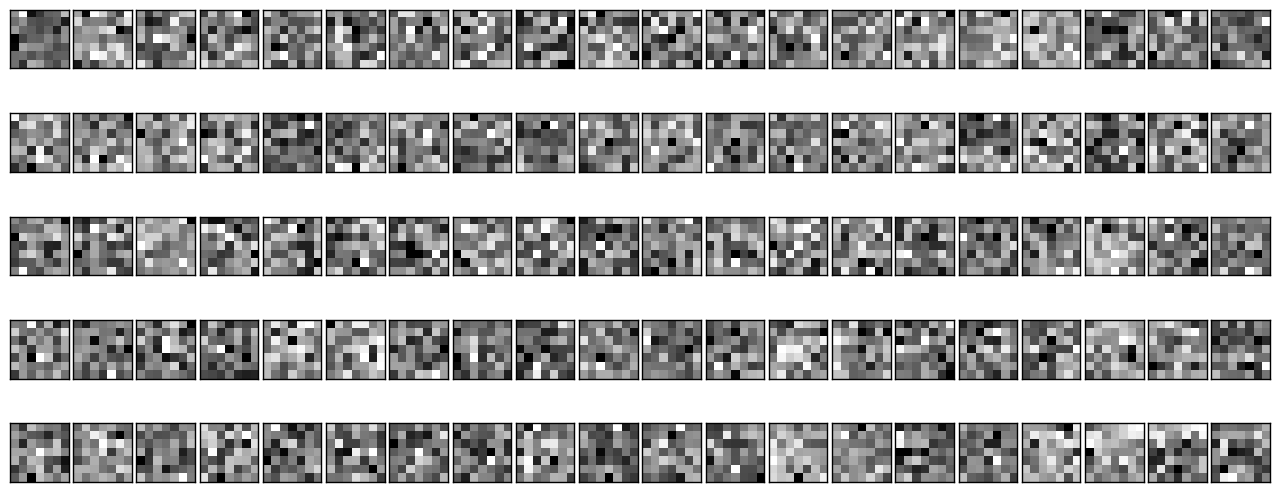

In [72]:
print('Learning the dictionary...')
t0 = time()
_, V = dict_learning_online(data, n_components=100, alpha=1, n_iter=500, dict_init=None, batch_size=1, shuffle=False, method='lars', inner_stats=None)
print('done in %.2fs.' % (time() - t0))

plt.figure(figsize=(15, 6))
for i, comp in enumerate(V[:100]):
    plt.subplot(5, 20, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

# with and without constant atom

Extracting unseen patches on the right half... 
done in 0.00s.
Encoding and decoding unseen patches of the right half with constant atom... 
done in 3.23s.
Encoding and decoding unseen patches of the right half without constant atom... 
done in 3.71s.


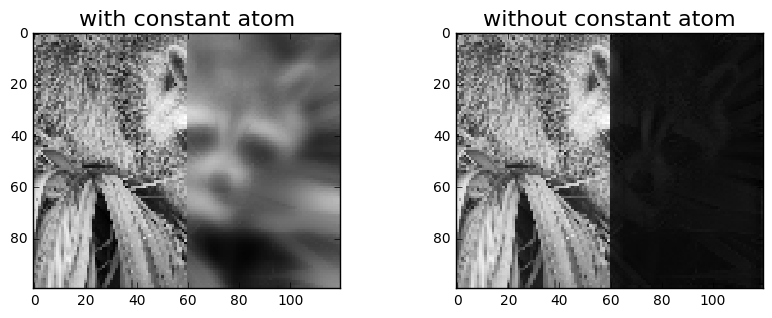

In [73]:
print('Extracting unseen patches on the right half... ')
t0 = time()
data = extract_patches_2d(face[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
print('done in %.2fs.' % (time() - t0))
new_V = np.concatenate((V, np.ones((1,V.shape[1]))), axis=0)

plt.figure(figsize=(10, 3.3))
plt.subplot(1, 2, 1)
print('Encoding and decoding unseen patches of the right half with constant atom... ')
t0 = time()
code = sparse_encode(data, new_V, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, new_V)
patches = patches.reshape(len(data), *patch_size)
reconstruction = face.copy()
reconstruction[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction, cmap=plt.cm.gray, interpolation='nearest')
plt.title("with constant atom", size=16)

plt.subplot(1, 2, 2)
print('Encoding and decoding unseen patches of the right half without constant atom... ')
t0 = time()
code = sparse_encode(data, V, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, V)
patches = patches.reshape(len(data), *patch_size)
reconstruction2 = face.copy()
reconstruction2[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction2, cmap=plt.cm.gray, interpolation='nearest')
plt.title("without constant atom", size=16)

plt.show()